# Code I

**Original \$x\_{t-1}\$ loss**
  $\mathbb{E}\Bigl[\|\tilde\mu_t(X_t,X_0)-\mu(X_t,t;\theta)\|^2/(2(1-\alpha_t))\Bigr]$

## (1) Network Architecture, this code provides a network $F(x,t;\theta)$ to compute $\mu(x,t;\theta)$ = $\rho_0(x-\rho_1(F(x,t;\theta)))$

---

This network implements a time-conditioned U-Net that, given a noisy image x_t and a continuous time index t, produces the model’s estimate μθ(x_t, t) of the “denoised” image at the previous timestep.

 1) Time embedding (Gaussian Fourier features → linear → Swish):

    - Encodes the scalar t into a high-dim vector, so every layer can know which noise level it’s operating at.

 2) Down-path (Encoder):
    
    - conv1 → group-norm → Swish
    - conv2 (stride-2) → norm → Swish
    - conv3 (stride-2) → norm → Swish
    - conv4 (stride-2) → norm → Swish
    At each block: we add a learned affine shift via Dense(embed)) so that the
    feature maps are modulated by the noise level t.

 3) Up-path (Decoder with skip-connections):
     
    - tconv4 (upsample) → add time-embed → norm → Swish
    - tconv3 on [current, encoder-h3] → add time-embed → norm → Swish
    - tconv2 on [current, encoder-h2] → add time-embed → norm → Swish
    - tconv1 on [current, encoder-h1]               → final output

 4) Output: a single-channel map of the same H×W, which can be transformed to μθ(x_t, t) in problem 2 with $\rho_1$ and $\rho_2$. During training this is compared to the true  $x_{t−1}$ sampled from q.

 By conditioning every convolutional block on t, the network learns a continuum of denoising functions that smoothly vary with the noise scale.

---

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x * self.W * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]

class ScoreNet_channel_reduc(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[16, 32, 64, 128], embed_dim=256, group_num=4):

    super().__init__()

    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))

    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(group_num, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(group_num, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(group_num, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(group_num, num_channels=channels[3])

    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(group_num, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(group_num, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(group_num, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    # Scalars ρ0 and ρ1 to learn
    self.rho0 = nn.Parameter(torch.ones(1))
    self.rho1 = nn.Parameter(torch.ones(1))
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))

    h1 = self.conv1(x) # ...
    h1 += self.dense1(embed) #...
    h1 = self.gnorm1(h1) # ...
    h1 = self.act(h1) # ...
    h2 = self.conv2(h1) # ...
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    h = self.tconv4(h4) # ...
    h += self.dense5(embed) # ...
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1)) # ...
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # compute the actual mean μ(x,t;θ) = ρ0 * (x - ρ1 * F(x,t;θ))
    mu_xt = self.rho0 * (x - self.rho1 * h)
    return mu_xt, h

## (2) A diffusion class that stores $\beta_t$, $\alpha_t$, $\bar{\alpha}_t$ and has a function to sample $x_{t-1}$, $x_{t}$ given $x_0$, one that predict the mean $\mu(x_t,t,\theta)$

In [2]:
class Diffusion(nn.Module):
    def __init__(self, model, n_steps, device, min_beta=1e-4, max_beta=0.1):
        super().__init__()
        self.model = model
        self.n_steps = n_steps
        self.device = device

        # linear beta schedule β₁…β_T
        self.betas = torch.linspace(min_beta, max_beta, n_steps, device=device)
        # α_t = 1 − β_t
        self.alphas = 1.0 - self.betas
        # \barα_t = ∏_{s=1}^t α_s
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

    def forward_process(self, x0, t):
        """
        Given x0 and integer timestep t (1 ≤ t < n_steps),
        returns (x_{t-1}, x_t) ~ q(x_{t-1}, x_t | x0).
        """
        # grab scalars for this batch
        # abar_t   = self.alpha_bar[t    ].view(-1, *([1] * (x0.ndim-1)))
        abar_t_1 = self.alpha_bar[t - 1].view(-1, *([1] * (x0.ndim-1)))
        alpha_t = self.alphas[t].view(-1, *([1] * (x0.ndim-1)))

        noise_t   = torch.randn_like(x0)
        noise_tm1 = torch.randn_like(x0)

        #x_t   = torch.sqrt(abar_t)   * x0 + torch.sqrt(1 - abar_t)   * noise_t
        x_tm1 = torch.sqrt(abar_t_1) * x0 + torch.sqrt(1 - abar_t_1) * noise_tm1
        x_t   = torch.sqrt(alpha_t) * x_tm1 + torch.sqrt(1 - alpha_t) * noise_t
        return x_tm1, x_t

    def predict_next(self, xt, t):
        """
        Given a noisy xt at timestep t, use the learned model to
        predict the reverse‐mean μ(xt,t;θ).
        """
        # assume model(xt, t) returns μ directly
        mu_xt = self.model(xt, t)
        return mu_xt


## (3) Loss function for diffusion model

---
When training a diffusion model, we need to approximate the expectation over random timesteps
$$
\mathbb{E}_{t\sim\text{Uniform}\{1,\dots,T-1\}}
\bigl[\ell(X_t, X_{t-1};\theta)\bigr],
$$
where for a single draw $t_j$ the per-example loss is
$$
\ell_j
=
\frac{\|X_{t_j-1} - \mu(X_{t_j},t_j;\theta)\|^2}
     {2\,(1-\alpha_{t_j})}\,.
$$
Using only one sample $t_j$ gives a Monte Carlo estimator with variance $\mathrm{Var}(\ell_j)$.  To reduce this variance by a factor of \(K\), we can draw \(K\) independent timesteps per example:
$$
t_{j,1},\,t_{j,2},\,\dots,\,t_{j,K}
\;\overset{\mathrm{i.i.d.}}{\sim}\;
\mathrm{Uniform}\{1,\dots,T-1\}.
$$
For each $k=1,\dots,K$ compute the corresponding noise pair $(X_{t_{j,k}-1},X_{t_{j,k}})$ and loss
$$
\ell_{j,k}
=
\frac{\bigl\|X_{t_{j,k}-1}-\mu(X_{t_{j,k}},t_{j,k};\theta)\bigr\|^2}
     {2\,(1-\alpha_{t_{j,k}})}.
$$
Then average them to get the per-example loss
$$
L_j^{(K)}
=
\frac{1}{K}\sum_{k=1}^K \ell_{j,k}
=
\frac{1}{K}\sum_{k=1}^K
\frac{\bigl\|X_{t_{j,k}-1}-\mu(X_{t_{j,k}},t_{j,k};\theta)\bigr\|^2}
     {2\,(1-\alpha_{t_{j,k}})}.
$$
Since the $\ell_{j,k}$ are independent conditioned on \(X_j\), the variance of their mean drops by \(1/K\):
$$
\mathrm{Var}\bigl(L_j^{(K)}\bigr)
=\frac{1}{K^2}\sum_{k=1}^K \mathrm{Var}(\ell_{j,k})
=\frac{1}{K}\,\mathrm{Var}(\ell_{j,1}).
$$
Thus, drawing multiple timesteps per example directly reduces the Monte Carlo noise in our loss estimate by approximately a factor of \(K\).

---

In [4]:
def batch_diffusion_loss_multi_t(X0: torch.Tensor,
                                 diff: Diffusion,
                                 K: int = 4):
    """
    For each of the b examples, draw K random timesteps,
    sample (x_{t-1}, x_t), compute the loss L_jk, average
    over k=1..K, then average over j=1..b.
    """
    b = X0.shape[0]
    device = X0.device
    T = diff.n_steps

    # 1) Draw K timesteps per example: shape (b, K)
    t = torch.randint(1, T, (b, K), device=device)

    # 2) Flatten everything to a big batch of size b*K
    t_flat = t.view(-1)                             # (b*K,)
    # expand X0 to (b, K, C, H, W) then flatten → (b*K, C, H, W)
    X0_exp = X0.unsqueeze(1).expand(-1, K, *X0.shape[1:]).contiguous()
    X0_flat = X0_exp.view(-1, *X0.shape[1:])        # (b*K, C, H, W)

    # 3) Sample forward-process pairs for each of the b*K samples
    x_tm1_flat, x_t_flat = diff.forward_process(X0_flat, t_flat)

    # 4) Predict μ(x_t, t) and compute squared errors
    t_model_flat = t_flat.float().unsqueeze(-1)                        # → (b*K,1)
    mu_flat, _   = diff.predict_next(x_t_flat, t_model_flat)          # → (b*K,C,H,W)
    err_flat     = (x_tm1_flat - mu_flat).view(b*K, -1).pow(2).sum(1)   # → (b*K,)

    # 5) Denominator 2*(1 - α_t)
    one_minus_alpha = (1 - diff.alphas[t_flat]).view(b*K)            # (b*K,)
    loss_flat = err_flat / (2 * one_minus_alpha)                     # (b*K,)

    # 6) Reshape back to (b, K), average over K, then over b
    loss_per_example = loss_flat.view(b, K).mean(dim=1)              # (b,)
    return loss_per_example.mean()                                  # scalar


## (4) Write code that minimizes the loss in (3)

In [5]:
from google.colab import drive
drive.mount('/content/drive')
predir = '/content/drive/My Drive/LSDA/'
import h5py
import torch
import numpy as np
# Torch functions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Utility to track progress of a routine.
from tqdm.notebook import trange, tqdm

# Folder with data
datadir=predir+'data/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [7]:
def get_mnist():
    data=np.float64(np.load(datadir+'mnist/MNIST_data.npy'))
    labels=np.float32(np.load(datadir+'mnist/MNIST_labels.npy'))
    print('Mnist data shape',data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:50000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:50000])
    val_dat=data[50000:60000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[50000:60000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])

    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)
(train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels) = get_mnist()

Mnist data shape (70000, 784)


In [26]:
from torch.utils.data import DataLoader, Subset, TensorDataset
from torch.optim.lr_scheduler import StepLR


In [9]:
T          = 200
batch_size = 100
n_epochs   = 60
lr_main    = 1e-2       # for U-Net parameters
lr_rho     = 2e-1       # for rho0, rho1
step_size  = 20
gamma      = 0.1
K          = 4          # variance-reduction steps

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 2) Build DataLoaders ---
train_ds = TensorDataset(
    torch.from_numpy(train_dat).float(),
    torch.from_numpy(train_labels).long()
)
val_ds = TensorDataset(
    torch.from_numpy(val_dat).float(),
    torch.from_numpy(val_labels).long()
)

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, drop_last=True
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, drop_last=False
)

# --- 3) Instantiate the channel-reduced model & its Diffusion wrapper ---
model_channel_reduc = ScoreNet_channel_reduc().to(device)
diff_channel_reduc = Diffusion(
    model_channel_reduc,
    n_steps=T,
    device=device,
    min_beta=1e-4,
    max_beta=1e-1
)

# --- 4) Optimizer & LR scheduler ---
opt = torch.optim.Adam([
    {
        'params': [model_channel_reduc.rho0,
                   model_channel_reduc.rho1],
        'lr': lr_rho
    },
    {
        'params': [
            p for n, p in model_channel_reduc.named_parameters()
            if n not in ('rho0', 'rho1')
        ],
        'lr': lr_main
    }
])
sched = StepLR(opt, step_size=step_size, gamma=gamma)

# --- 5) Training + Validation Loop ---
for epoch in range(1, n_epochs + 1):
    # Train
    model_channel_reduc.train()
    train_loss = 0.0
    for X0, _ in train_loader:
        X0 = X0.to(device)
        opt.zero_grad()
        loss = batch_diffusion_loss_multi_t(
            X0,
            diff_channel_reduc,
            K=K
        )
        loss.backward()
        opt.step()
        train_loss += loss.item() * X0.size(0)
    sched.step()
    train_loss /= len(train_loader.dataset)

    # Validate
    model_channel_reduc.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X0, _ in val_loader:
            X0 = X0.to(device)
            loss = batch_diffusion_loss_multi_t(
                X0,
                diff_channel_reduc,
                K=K
            )
            val_loss += loss.item() * X0.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss = {train_loss:.4f},  Val Loss = {val_loss:.4f}")


Epoch 01: Train Loss = 1837.2164,  Val Loss = 388.5246
Epoch 02: Train Loss = 388.2903,  Val Loss = 388.1732
Epoch 03: Train Loss = 388.0494,  Val Loss = 388.1374
Epoch 04: Train Loss = 388.0982,  Val Loss = 387.9517
Epoch 05: Train Loss = 388.0137,  Val Loss = 388.0246
Epoch 06: Train Loss = 387.9132,  Val Loss = 388.0013
Epoch 07: Train Loss = 387.9251,  Val Loss = 387.8171
Epoch 08: Train Loss = 387.8083,  Val Loss = 387.6487
Epoch 09: Train Loss = 387.6485,  Val Loss = 387.5766
Epoch 10: Train Loss = 387.3434,  Val Loss = 387.1341
Epoch 11: Train Loss = 387.0493,  Val Loss = 386.7818
Epoch 12: Train Loss = 386.4010,  Val Loss = 386.1786
Epoch 13: Train Loss = 385.8707,  Val Loss = 385.5326
Epoch 14: Train Loss = 385.3094,  Val Loss = 385.0841
Epoch 15: Train Loss = 384.8445,  Val Loss = 384.4864
Epoch 16: Train Loss = 384.6450,  Val Loss = 384.3978
Epoch 17: Train Loss = 384.3590,  Val Loss = 383.9833
Epoch 18: Train Loss = 383.8000,  Val Loss = 383.6239
Epoch 19: Train Loss = 383.

## (5) Sample from the trained model

---
Reverse sample Procedure:
$$
x_{t-1} \;=\; \mu\bigl(x_t, t; \theta\bigr)\;+\;\sqrt{1 - \alpha_t}\,Z_t
\,,\quad
t = T,\,T-1,\,\dots,\,1.
$$

---

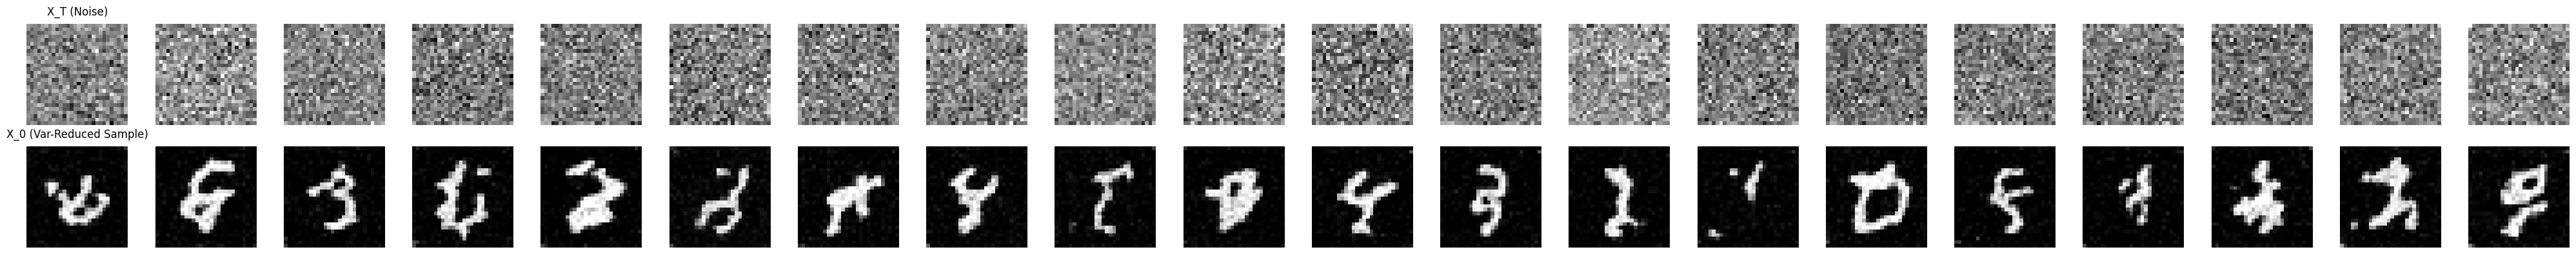

In [10]:
import torch
import matplotlib.pyplot as plt

# 1) Draw a batch of noise X_T
n = 20
shape = (n, 1, 28, 28)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_T = torch.randn(shape, device=device)

# 2) Define the sampling function (reuse your @torch.no_grad one)
@torch.no_grad()
def sample_batch(model, diff, noise_batch):
    model.eval()
    x = noise_batch.clone()
    for t in reversed(range(1, diff.n_steps)):
        # integer timesteps for alphas
        t_int = t
        # float timesteps for the network
        t_tensor = torch.full((x.size(0),), t_int, device=device, dtype=torch.float).unsqueeze(-1)
        # model predicts mean
        mu, _ = model(x, t_tensor)
        # fixed variance
        sigma = torch.sqrt(1 - diff.alphas[t_int]).to(device)
        noise = torch.randn_like(x) if t_int > 1 else 0.0
        x = mu + sigma * noise
    return x.clamp(0.0, 1.0)

# 3) Sample X_0 from your variance‐reduced model
X_0_var = sample_batch(model_channel_reduc, diff_channel_reduc, X_T)

# 4) Plot side‐by‐side
fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
for i in range(n):
    axes[0, i].imshow(X_T[i, 0].cpu(), cmap='gray', interpolation='nearest')
    axes[0, i].axis('off')
    axes[1, i].imshow(X_0_var[i, 0].cpu(), cmap='gray', interpolation='nearest')
    axes[1, i].axis('off')

axes[0, 0].set_title('X_T (Noise)', pad=10)
axes[1, 0].set_title('X_0 (Var-Reduced Sample)', pad=10)
plt.tight_layout()
plt.show()


In [15]:
import torch
import matplotlib.pyplot as plt

# 1) Draw a batch of noise X_T
n = 20
shape = (n, 1, 28, 28)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_T = torch.randn(shape, device=device)

# 2) Define the sampling function
@torch.no_grad()
def sample_images(model, diff, noise_batch):
    model.eval()
    x = noise_batch.clone()
    for t in reversed(range(1, diff.n_steps)):
        t_tensor = torch.full((n,), t, device=device, dtype=torch.float).unsqueeze(-1)
        mu, _ = model(x, t_tensor)
        sigma = torch.sqrt(1 - diff.alphas[t]).to(device)
        eps   = torch.randn_like(x) if t > 1 else 0.0
        x = mu + sigma * eps
    return x.clamp(0,1)



## (6) Compute the FID Score between original image and 1000 samples from the trained model

In [16]:
import numpy as np

def matrix_sqrt(A):
    eigenvalues, U = np.linalg.eigh(A)
    if np.any(eigenvalues < 0):
        raise ValueError("Matrix is not positive definite: found negative eigenvalues")
    sqrt_eigenvalues = np.sqrt(eigenvalues)

    Lambda_sqrt = np.diag(sqrt_eigenvalues)

    A_sqrt = U @ Lambda_sqrt @ U.T
    return A_sqrt



def compute_fid(sample1, sample2, eps=1e-6):
    mu1 = np.mean(sample1, axis=0)
    mu2 = np.mean(sample2, axis=0)

    cov1 = np.cov(sample1, rowvar=False) + np.eye(sample1.shape[1])*eps
    cov2 = np.cov(sample2, rowvar=False) + np.eye(sample2.shape[1])*eps

    diff = np.sum((mu1 - mu2)**2)

    cov1_sqrt = matrix_sqrt(cov1)
    temp      = cov1_sqrt @ cov2 @ cov1_sqrt
    temp_sqrt = matrix_sqrt(temp)

    fid = diff + np.trace(cov1 + cov2 - 2*temp_sqrt)
    return np.real_if_close(fid)


In [17]:

# 1) Generate 1k samples from your trained model
n = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise = torch.randn(n, 1, 28, 28, device=device)


gen_imgs = sample_images( model_channel_reduc, diff_channel_reduc, noise)
# flatten to (1000, 28*28)
gen_flat  = gen_imgs.cpu().numpy().reshape(n, -1)

# 2) Grab 1k real MNIST images
idxs = np.random.choice(train_dat.shape[0], size=n, replace=False)
real_flat = train_dat[idxs].reshape(n, -1)  # already float32 in [0,1]


# 4) Compute FID
fid_value = compute_fid(real_flat, gen_flat)
print(f"FID over 1 000 samples: {fid_value:.4f}")


FID over 1 000 samples: 8.1425


# Code II
**Noise ($\epsilon$) loss**
  $\mathbb{E}\Bigl[\tfrac{1-\alpha_t}{2\alpha_t(1-\bar\alpha_t)}\|\,\epsilon_t - e_\theta(X_t,t)\|^2\Bigr]$

## (1) Network Architecture, this code provides a network $e_t(x,t;\theta)$ which can be used to calculate loss in part (3)

In [ ]:
class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[32, 64, 128, 256], embed_dim=256, group_num=4):

    super().__init__()

    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))

    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(group_num, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(group_num, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(group_num, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(group_num, num_channels=channels[3])

    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(group_num, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(group_num, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(group_num, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t, x is (batch_size,  C,  H,  W)
    embed = self.act(self.embed(t))

    h1 = self.conv1(x) # ...
    h1 += self.dense1(embed) #...
    h1 = self.gnorm1(h1) # ...
    h1 = self.act(h1) # ...
    h2 = self.conv2(h1) # ...
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    h = self.tconv4(h4) # ...
    h += self.dense5(embed) # ...
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1)) # ...
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    return h

## (2) A diffusion class that stores $\beta_t$, $\alpha_t$, $\bar{\alpha}_t$ and has a function to sample $x_{t}$, $\epsilon_t$ given $x_0$, one that predict $e_t(x_t,t,\theta)$

In [ ]:
from math import e
class Diffusion_codeII(nn.Module):
    def __init__(self, model, n_steps, device, min_beta=1e-4, max_beta=0.1):
        super().__init__()
        self.model = model
        self.n_steps = n_steps
        self.device = device

        # linear beta schedule β₁…β_T
        self.betas = torch.linspace(min_beta, max_beta, n_steps, device=device)
        # α_t = 1 − β_t
        self.alphas = 1.0 - self.betas
        # \barα_t = ∏_{s=1}^t α_s
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

    def forward_process(self, x0, t):
        """
        Given x0 and integer timestep t (1 ≤ t < n_steps),
        returns (x_{t-1}, x_t) ~ q(x_{t-1}, x_t | x0).
        """
        # grab scalars for this batch
        abar_t   = self.alpha_bar[t    ].view(-1, *([1] * (x0.ndim-1)))
        abar_t_1 = self.alpha_bar[t - 1].view(-1, *([1] * (x0.ndim-1)))
        alpha_t = self.alphas[t].view(-1, *([1] * (x0.ndim-1)))

        noise_t   = torch.randn_like(x0)
        noise_tm1 = torch.randn_like(x0)

        x_t   = torch.sqrt(abar_t)   * x0 + torch.sqrt(1 - abar_t)   * noise_t
        # x_tm1 = torch.sqrt(abar_t_1) * x0 + torch.sqrt(1 - abar_t_1) * noise_tm1
        # x_t   = torch.sqrt(alpha_t) * x_tm1 + torch.sqrt(1 - alpha_t) * noise_t
        return x_t, noise_t

    def predict_next(self, xt, t):
        """
        Given a noisy xt at timestep t, use the learned model to
        predict the reverse‐mean μ(xt,t;θ).
        """
        # assume model(xt, t) returns μ directly
        e_xt = self.model(xt, t)
        return e_xt


## (3) define the noise‐prediction loss function 
  $$\mathbb{E}\Bigl[\tfrac{1-\alpha_t}{2\alpha_t(1-\bar\alpha_t)}\|\,\epsilon_t - e_\theta(X_t,t)\|^2\Bigr]$$

In [ ]:
def batch_diffusion_loss_CodeII(X0, diff):
    b      = X0.shape[0]
    device = X0.device
    T      = diff.n_steps

    # 1) draw integer timesteps for each sample
    t_int = torch.randint(1, T, (b,), device=device)      # (b,)

    # 2) sample x_t and the noise ε used
    x_t, noise_t = diff.forward_process(X0, t_int)         # each (b,1,H,W)

    # 3) prepare t for the model
    t_model = t_int.float().unsqueeze(-1)                  # (b,1)

    # 4) predict the noise ε_θ(x_t,t)
    e_xt = diff.predict_next(x_t, t_model)                 # (b,1,H,W)

    # 5) squared‐error term ‖ε − ε_θ‖²
    err = (noise_t - e_xt).view(b, -1).pow(2).sum(dim=1)    # (b,)

    # 6) weight term: (1−α_t) / [2 α_t (1−\barα_t)]
    alpha_t    = diff.alphas[t_int]                        # (b,)
    alpha_bar_t= diff.alpha_bar[t_int]                     # (b,)
    w = (1 - alpha_t) / (2 * alpha_t * (1 - alpha_bar_t))  # (b,)

    losses = err * w                                        # (b,)
    return losses.mean()


## (4) Write code that minimizes the loss in (3)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim.lr_scheduler import StepLR

# --- 0) Hyperparameters ---
T          = 200
batch_size = 100
n_epochs   = 60
lr_main    = 1e-2       # for U-Net weights
step_size  = 20
gamma      = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 1) Prepare MNIST DataLoaders with a holdout validation set ---
# Assume get_mnist() already loaded train_dat/train_labels and val_dat/val_labels
train_ds = TensorDataset(
    torch.from_numpy(train_dat).float(),
    torch.from_numpy(train_labels).long()
)
val_ds = TensorDataset(
    torch.from_numpy(val_dat).float(),
    torch.from_numpy(val_labels).long()
)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)

# --- 2) Instantiate model_codeII and diffusion wrapper ---
model_codeII = ScoreNet().to(device)
diff_codeII  = Diffusion_codeII(model_codeII, n_steps=T, device=device,
                                min_beta=1e-4, max_beta=1e-1)

# --- 3) Optimizer & Scheduler ---
opt_codeII   = torch.optim.Adam(model_codeII.parameters(), lr=lr_main)
sched_codeII = StepLR(opt_codeII, step_size=step_size, gamma=gamma)

# --- 4) Training + Validation Loop ---
for epoch in range(1, n_epochs+1):
    # ---- Training ----
    model_codeII.train()
    train_loss = 0.0
    for X0, _ in train_loader:
        X0 = X0.to(device)
        opt_codeII.zero_grad()
        loss = batch_diffusion_loss_CodeII(X0, diff_codeII)
        loss.backward()
        opt_codeII.step()
        train_loss += loss.item() * X0.size(0)
    sched_codeII.step()
    train_loss /= len(train_loader.dataset)

    # ---- Validation ----
    model_codeII.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X0, _ in val_loader:
            X0 = X0.to(device)
            loss = batch_diffusion_loss_CodeII(X0, diff_codeII)
            val_loss += loss.item() * X0.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"[Epoch {epoch:02d}]  Train Loss = {train_loss:.5f},  Val Loss = {val_loss:.5f}")


[Epoch 01]  Train Loss = 16.58035,  Val Loss = 9.08626
[Epoch 02]  Train Loss = 7.66368,  Val Loss = 6.03136
[Epoch 03]  Train Loss = 5.05393,  Val Loss = 4.75016
[Epoch 04]  Train Loss = 4.10896,  Val Loss = 3.56212
[Epoch 05]  Train Loss = 3.90341,  Val Loss = 3.75331
[Epoch 06]  Train Loss = 3.51553,  Val Loss = 3.48026
[Epoch 07]  Train Loss = 3.34724,  Val Loss = 3.48609
[Epoch 08]  Train Loss = 3.50229,  Val Loss = 3.18020
[Epoch 09]  Train Loss = 3.59688,  Val Loss = 3.70853
[Epoch 10]  Train Loss = 3.22971,  Val Loss = 2.76357
[Epoch 11]  Train Loss = 3.36341,  Val Loss = 3.27190
[Epoch 12]  Train Loss = 3.26608,  Val Loss = 3.35851
[Epoch 13]  Train Loss = 3.39174,  Val Loss = 3.00766
[Epoch 14]  Train Loss = 3.13615,  Val Loss = 3.28384
[Epoch 15]  Train Loss = 3.75911,  Val Loss = 3.60597
[Epoch 16]  Train Loss = 3.56403,  Val Loss = 6.69918
[Epoch 17]  Train Loss = 3.86036,  Val Loss = 3.35532
[Epoch 18]  Train Loss = 3.49795,  Val Loss = 3.26915
[Epoch 19]  Train Loss = 2.

## (5) Sample from the trained model

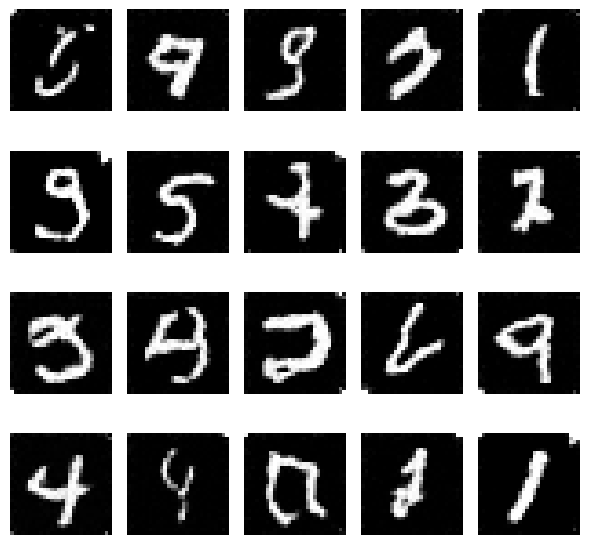

In [ ]:
import torch

@torch.no_grad()
def sample_eq5(model, diff, n_samples=1000, device='cpu'):
    model.eval()
    x = torch.randn(n_samples, 1, 28, 28, device=device)

    for t in reversed(range(1, diff.n_steps)):
        t_int    = t
        # prepare timestep for network
        t_tensor = torch.full((n_samples,), t_int, device=device,
                              dtype=torch.float).unsqueeze(-1)

        # predict noise εθ
        e_t = model(x, t_tensor)  # shape (n,1,28,28)

        # fetch scalars
        alpha_t     = diff.alphas[t_int]        # α_t
        alpha_bar_t = diff.alpha_bar[t_int]     # \bar α_t
        alpha_bar_t_1 = diff.alpha_bar[t_int-1] # \bar α_{t-1}

        # mean per eq (5)
        coef = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        mu_t = (x - coef * e_t) / torch.sqrt(alpha_t)

        # correct reverse-step variance
        beta_tilde = (1 - alpha_t) * (1 - alpha_bar_t_1) / (1 - alpha_bar_t)

        # sample x_{t-1}
        if t_int > 1:
            noise = torch.randn_like(x)
            x = mu_t + torch.sqrt(beta_tilde) * noise
        else:
            x = mu_t

    return x.clamp(0.0, 1.0)
# --- Usage example ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
samples = sample_eq5(model_codeII, diff_codeII, n_samples=20, device=device)

# plot a 4×4 grid
fig, axes = plt.subplots(4, 5, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i,0].cpu(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

## (6) Compute FID score

In [ ]:
import torch
import numpy as np

# 1) Sampling function using Eq. (5)
@torch.no_grad()
def sample_eq5(model, diff, n_samples=1000, device='cpu'):
    model.eval()
    x = torch.randn(n_samples, 1, 28, 28, device=device)
    for t in reversed(range(1, diff.n_steps)):
        t_int    = t
        t_tensor = torch.full((n_samples,), t_int, device=device, dtype=torch.float).unsqueeze(-1)
        e_t      = model(x, t_tensor)  # predict noise
        alpha_t     = diff.alphas[t_int]
        alpha_bar_t = diff.alpha_bar[t_int]
        beta_t      = diff.betas[t_int]
        # compute mu(x_t, t) per Eq.(5)
        coef = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        mu_t = (x - coef * e_t) / torch.sqrt(alpha_t)
        # reverse sample
        if t_int > 1:
            noise = torch.randn_like(x)
            x = mu_t + torch.sqrt(beta_t) * noise
        else:
            x = mu_t
    return x.clamp(0.0, 1.0)

# 2) Draw 1 000 generated samples
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gen_imgs = sample_eq5(model_codeII, diff_codeII, n_samples=1000, device=device)
gen_flat = gen_imgs.cpu().numpy().reshape(1000, -1)  # (1000, 784)

# 3) Draw 1 000 real MNIST samples
idxs      = np.random.choice(train_dat.shape[0], size=1000, replace=False)
real_flat = train_dat[idxs].reshape(1000, -1)        # (1000, 784)

# 4) Compute FID
fid_score = compute_fid(real_flat, gen_flat, eps=1e-6)
print(f"FID over 1000 samples: {fid_score:.4f}")


FID over 1000 samples: 6.5661


# Comparison between Code I and Code II loss

---
The two formulations are mathematically equivalent but lead to rather different practical losses:

* **Original \$x\_{t-1}\$ loss**
  $\mathbb{E}\Bigl[\|\tilde\mu_t(X_t,X_0)-\mu(X_t,t;\theta)\|^2/(2(1-\alpha_t))\Bigr]$
  requires the model to directly predict the reverse‐step mean $\mu(X_t,t)$ and carries an explicit time‐dependent weight $1/(1-\alpha_t)$.  Because $1-\alpha_t$ is small at early timesteps, this can blow up the loss or force very small learning‐rates.

* **Noise ($\epsilon$) loss**
  $\mathbb{E}\Bigl[\tfrac{1-\alpha_t}{2\alpha_t(1-\bar\alpha_t)}\|\,\epsilon_t - e_\theta(X_t,t)\|^2\Bigr]$
  re‐parameterizes so the network simply predicts the Gaussian noise $\epsilon_t$.  The resulting objective is a plain squared‐error on noise, with only mild, well‐behaved time‐dependent weights.

**Observable differences in practice**

1. The noise‐prediction loss tends to be more stable and recover results are more like numbers. It simplifies the network’s task to “denoise” rather than learn both scale and shift, often resulting in faster convergence and better sample quality.
3. Because the weights \$(1-\alpha\_t)/(\alpha\_t(1-\bar\alpha\_t))\$ stay bounded, training is less sensitive to the choice of timestep schedule.

---